In [81]:
import cv2
import numpy as np
import numpy.ma as ma
import os, glob, re
import shutil
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

In [82]:
def convolve(image, kernel):
    # grab the spatial dimensions of the image, along with the spatial dimensions of the kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
 
    # allocate memory for the output image, taking care to
    # "pad" the borders of the input image so the spatial
    # size (i.e., width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
        cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float32")
    
    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top to
    # bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
 
            # perform the actual convolution by taking the
            # element-wise multiplicate between the ROI and
            # the kernel, then summing the matrix
            k = (roi * kernel).sum()
 
            # store the convolved value in the output (x,y)-
            # coordinate of the output image
            output[y - pad, x - pad] = k
            
    # rescale the output image to be in the range [0, 255]
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
 
    # return the output image
    return output

In [83]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [84]:
def clearUpperPart(img):
    newImg = img.copy()
    for x in range((int)(newImg.shape[0]/2)):
        for y in range(newImg.shape[1]):
            newImg[x,y] = 0
    return newImg

In [85]:
def MaskRow(img,row):
    newImg = img.copy()
    for x in range(newImg.shape[0]):
        for y in range(newImg.shape[1]):
            if(x != row):
                newImg[x,y] = 0
    return newImg

In [86]:
def thresholdClearAbove(img,threshold):
    newImg = img.copy()
    for x in range(newImg.shape[0]):
        for y in range(newImg.shape[1]):
            if(newImg[x,y] > threshold):
                newImg[x,y] = 255
    return newImg

In [87]:
def thresholdClearBelow(img,threshold):
    newImg = img.copy()
    for x in range(newImg.shape[0]):
        for y in range(newImg.shape[1]):
            if(newImg[x,y] < threshold):
                newImg[x,y] = 0
    return newImg

In [88]:
def Binarize(img,threshold):
    newImg = img.copy()
    for x in range(newImg.shape[0]):
        for y in range(newImg.shape[1]):
            if(newImg[x,y] < threshold):
                newImg[x,y] = 0
            else:
                newImg[x,y] = 255
    return newImg

In [89]:
def getVerticalPixels(img,row):
    newImg = img.copy()
    for y in range(newImg.shape[1]):
        blackValue = 0
        pixelsAdded = 0
        if(y > 0):
            for x in range(newImg.shape[0]):
                blackValue += (255 - newImg[x,y-1]) * 2
                pixelsAdded += 1
        if(y < newImg.shape[1] - 1):
            for x in range(newImg.shape[0]):
                blackValue += (255 - newImg[x,y+1]) * 2
                pixelsAdded += 1
        for x in range(newImg.shape[0]):
            if(x == row):
                continue
            blackValue += (255 - newImg[x,y]) * 5
            pixelsAdded += 1
        
        newImg[row,y] = min((newImg[row,y] + (blackValue / pixelsAdded)),255)
    return newImg

In [90]:
def calculateVerticalPixelsInLowerHalf(mainImg,maskImage,row,threshold):
    newImg = mainImg.copy()
    for y in range(newImg.shape[1]):
        if(maskImage[row,y] < 240):
            continue
        blackValue = 0
        pixelsAdded = 0
        if(y > 0):
            for x in range(newImg.shape[0]/2):
                blackValue += (255 - newImg[x + newImg.shape[0] / 2 , y - 1])*4
                pixelsAdded += 1
        if(y < newImg.shape[1] - 1):
            for x in range(newImg.shape[0]/2):
                blackValue += (255 - newImg[x + newImg.shape[0] / 2, y + 1])*4
                pixelsAdded += 1
        for x in range(newImg.shape[0]/2):
            if(x == row):
                continue
            blackValue += (255 - newImg[x + newImg.shape[0] / 2 , y]) * 7
            pixelsAdded += 1
        
        if(min(newImg[row,y] + (blackValue / pixelsAdded),255) > threshold):
            maskImage[row,y] = 0
        newImg[row,y] = min(newImg[row,y] + (blackValue / pixelsAdded),255)
    return newImg

In [91]:
def calculateVerticalPixels(mainImg,maskImage,row,threshold):
    for y in range(mainImg.shape[1]):
        if(maskImage[row,y] < 240):
            continue
        blackValue = 0
        pixelsAdded = 0
        for x in range(mainImg.shape[0]):
            if(x == row):
                continue
            if(mainImg[x, y] == 0):
                pixelsAdded += 1
        
        #if(min(newImg[row,y] + (blackValue / pixelsAdded),255) > threshold):
        if(pixelsAdded > threshold):
            maskImage[row,y] = 0
        #newImg[row,y] = min(newImg[row,y] + (blackValue / pixelsAdded),255)

In [92]:
def AdjustMaskWithRange(maskImg,binImg,row):
    for y in range(maskImg.shape[1] - 1):
        index = maskImg.shape[1] - y - 2
        HasTwoAdjacentWhites = True
        whitePxlsRange = 3
        for pixelMargin in range(whitePxlsRange):
            if(binImg[row, index + pixelMargin - (int)(whitePxlsRange/2)] < 10):
                HasTwoAdjacentWhites = False
        if(HasTwoAdjacentWhites):
            maskImg[row, index] = 0
        else:
            if(maskImg[row, index] > 200 and maskImg[row,index - 1] < 10):
                maskImg[row, index] = 255
            else:
                maskImg[row, index] = 0

In [93]:
def AdjustMask(maskImg,binImg,row):
    for y in range(maskImg.shape[1] - 1):
        index = maskImg.shape[1] - y - 2
        if(maskImg[row, index] > 200 and maskImg[row,index - 1] < 10):
            maskImg[row, index] = 255
        else:
            maskImg[row, index] = 0

In [94]:
def GetBaseLine(binImg):
    leastLineBlackCount = 0
    baseline = 0
    for x in range(binImg.shape[0]):
        noBlack = 0
        for y in range(binImg.shape[1]):
            if(binImg[x,y] < 10):
                noBlack += 1
        if(noBlack >= (leastLineBlackCount*(3/4))):
            leastLineBlackCount = noBlack
            baseline = x
        #print(str(x) + " : " + str(noBlack))
    return baseline

In [95]:
def lettersFromMask(mainImg,maskImg,row):
    newImg = mainImg.copy()
    for y in range(newImg.shape[1] - 2):
        index = newImg.shape[1] - y - 1
        #if(maskImg[row, index] > 200 and maskImg[row,index - 1] < 10):
        if(maskImg[row, index] > 200):
            for x in range(newImg.shape[0]):
                newImg[x,index] = 125
    return newImg  

In [96]:
def detectHoles(binImg,maskImg,row):
    for y in range(binImg.shape[1]):
        if(maskImg[row,y] < 240):
            continue
        numberOfTransitions = 0
        for x in range(binImg.shape[0] - 1):
            if(binImg[x,y] != binImg[x+1,y]):
                numberOfTransitions += 1
        if(numberOfTransitions > 2):
            maskImg[row,y] = 0

In [97]:
def sepLetters(binImg,maskImg,row):
    for y in range(binImg.shape[1] - 1):
        whiteLastRow = True
        whiteCurrRow = True
        for x in range(binImg.shape[0]):
            if(binImg[x,y] < 10):
                whiteLastRow = False
        for x in range(binImg.shape[0]):
            if(binImg[x,y + 1] < 10):
                whiteCurrRow = False
        if(whiteLastRow and not whiteCurrRow):
            maskImg[row,y] = 255                

In [98]:
def removeContinousLines(binImg,maskImg,row):
    for y in range(binImg.shape[1] - 1):
        if(maskImg[row,y] < 240):
            continue
        movingOnContinousLine = True
        i = 1
        while i < binImg.shape[1] - 1:
            if(binImg[row,y+i] != binImg[row,y+i-1]):
                movingOnContinousLine = False
            if(maskImg[row,y+i] > 240):
                break
            i += 1
        if(movingOnContinousLine):
            maskImg[row,y+i] = 0          

In [99]:
def segment_characters(path_name, file_extention, img_num, img_Write_Location, debug = False):
    file_name = path_name  + str(img_num) + file_extention #"D:\\Faculty\\_Fourth year\\pattern\\Project\\ArabicOCR\\Results\\resultjpg0\\result" + str(img_count) + ".jpg"
    img = cv2.imread(file_name, 0)  #0 parameter means read it in grayscale
    if (debug):
        show_images([img],["Image"])
    
    img = thresholdClearAbove(img,230)
    
    # construct a sharpening filter
    sharpen = np.array((
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]), dtype="int")
    
    # construct a filter for horz line detection
    horz = np.array((
        [0, 2, 0],
        [0, -6, 0],
        [0, 2, 0]), dtype="int")
    
    # construct a filter for horz line detection
    horz = np.array((
        [2, 6, 2],
        [0, -18, 0],
        [2, 6, 2]), dtype="int")
    
    # construct a filter for horz line detection
    '''horz = np.array((
        [1, 2, 1],
        [-1, -8, -2],
        [1, 2, 1]), dtype="int")'''
    
    imgHorz = convolve(img, horz) #cv2.Laplacian(img,cv2.CV_64F) # convolve(imgSharp, horz)
    if (debug):
        show_images([imgHorz],["Horizontal lines"])
    
    thresholdCleared = thresholdClearBelow(imgHorz,250)
    if (debug):
        show_images([thresholdCleared],["Threshold Cleared"])
    
    binImage = Binarize(img,135)
    rowBaseLine = GetBaseLine(binImage)
    if (debug):
        print("Baseline : " + str(rowBaseLine))
    
    thresholdCleared = MaskRow(thresholdCleared,rowBaseLine)
    if (debug):
        show_images([thresholdCleared,binImage],["Mask Row","bin Image"])
    
    '''
    #AdjustMaskWithRange(thresholdCleared,13)
    
    #cutImage = lettersFromMask(img,thresholdCleared,13)
    #show_images([cutImage],["Letters"])
    #cutImage = Binarize(img,180)'''
    
    detectHoles(binImage,thresholdCleared,rowBaseLine)
    if (debug):
        show_images([binImage,thresholdCleared],["bin Image","detect Holes"])
    
    calculateVerticalPixels(binImage,thresholdCleared,rowBaseLine,2)
    if (debug):
        show_images([binImage,thresholdCleared],["bin Image","Vertical lines"])
    
    AdjustMaskWithRange(thresholdCleared,binImage,rowBaseLine)
    if (debug):
        show_images([binImage,thresholdCleared],["bin Image","Adjust Mask"])
    
    sepLetters(binImage,thresholdCleared,rowBaseLine)
    removeContinousLines(binImage,thresholdCleared,rowBaseLine)
    AdjustMask(thresholdCleared,binImage,rowBaseLine)
    if (debug):
        show_images([binImage,thresholdCleared],["bin Image","Sep Letters"])
    
    lettersSegmented = lettersFromMask(img,thresholdCleared,rowBaseLine)
    show_images([lettersSegmented],["Letters Segmented"])
    
    #cv2.imwrite(img_Write_Location + str(img_num) + '.png',lettersSegmented)
    

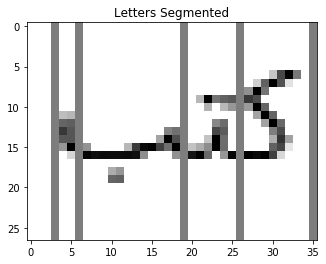

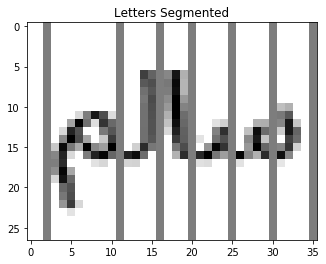

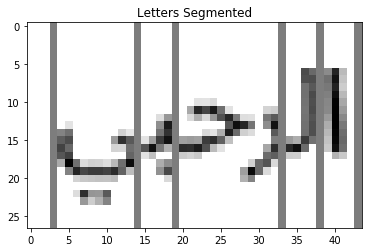

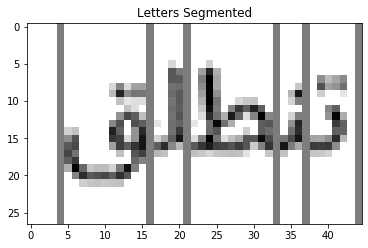

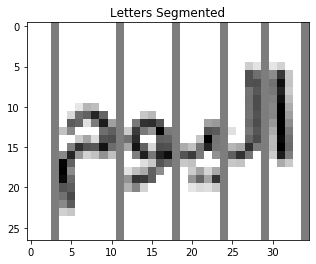

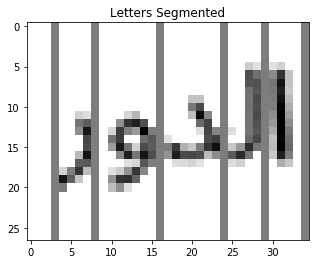

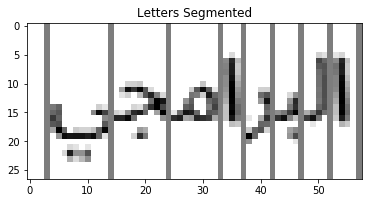

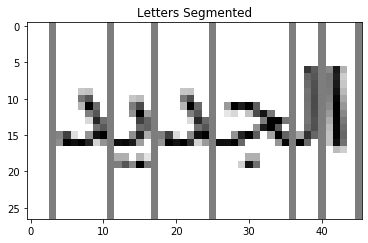

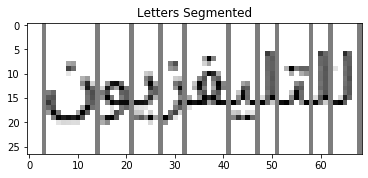

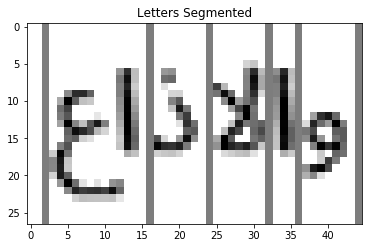

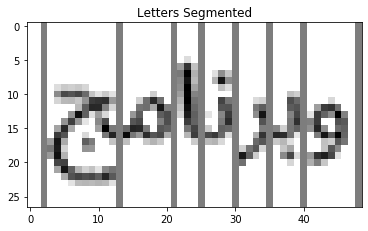

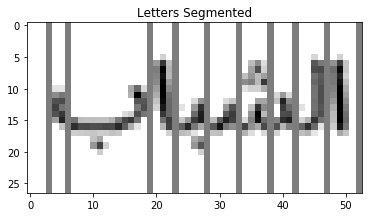

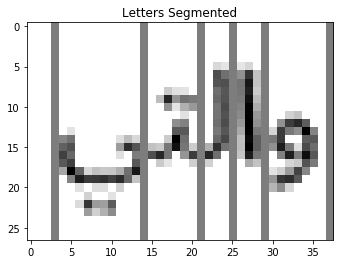

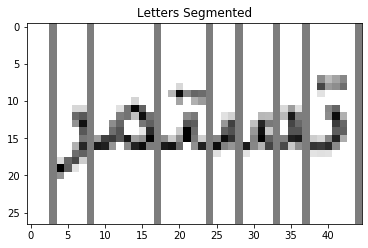

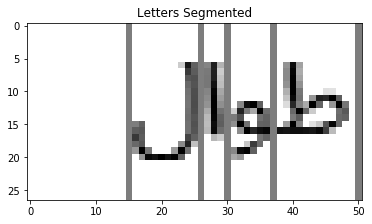

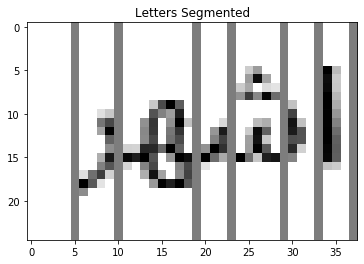

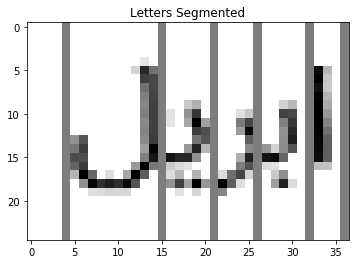

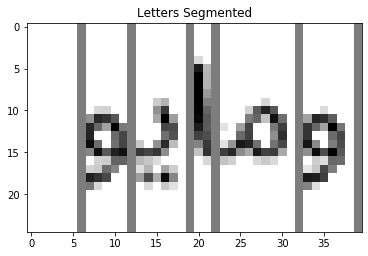

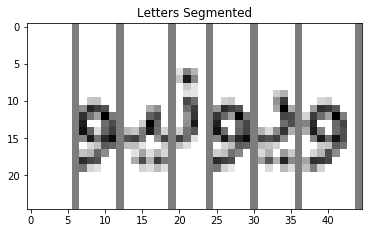

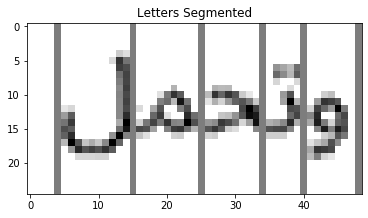

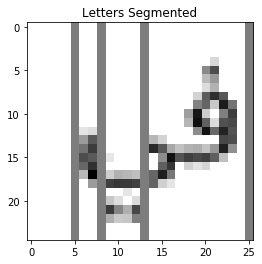

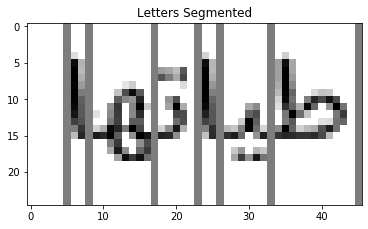

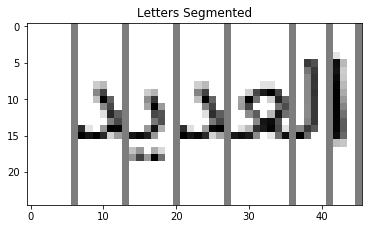

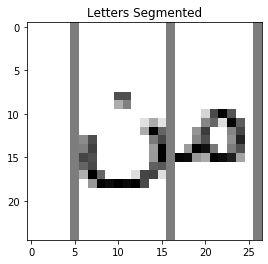

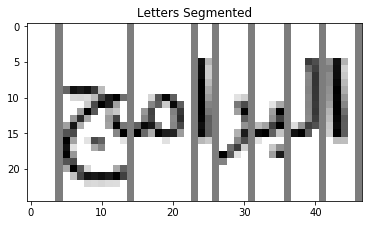

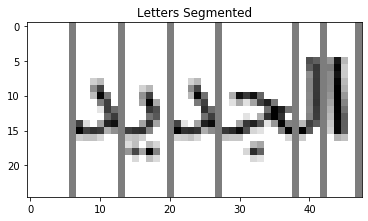

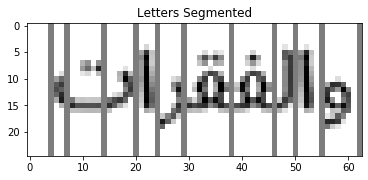

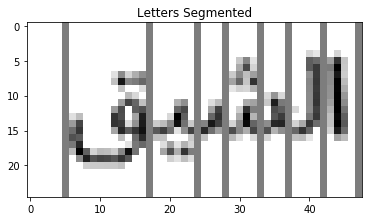

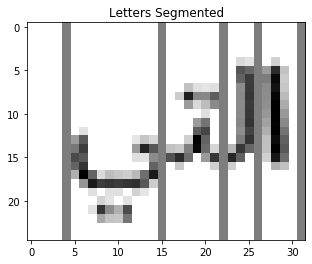

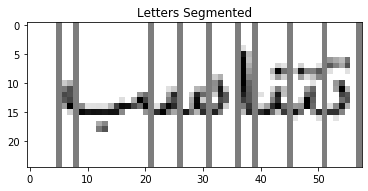

In [100]:
testcases = 30
x = 17

path_name = "D:\\Faculty\\_Fourth year\\pattern\\Project\\ArabicOCR\\Results\\resultjpg0\\result"
image_extention = ".jpg"

img_Write_Location = "D:/Faculty/_Fourth year/pattern/Project/ArabicOCR/CharResults3/word"


for x in range(testcases):
    segment_characters(path_name, image_extention, x, img_Write_Location, debug = False)